In [94]:
import numpy as np
import os
import netCDF4
from scipy import stats
from scipy import linalg as lin
from scipy import signal as sig
from matplotlib import pyplot as plt
%matplotlib inline

In [95]:
from sstanalysis import gfd
from sstanalysis import popmodel
reload(popmodel)

<module 'sstanalysis.popmodel' from 'sstanalysis/popmodel.pyc'>

The Fourier pairs are

$$ \theta(x,y) = \frac{1}{(2\pi)^2} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \hat{\theta}(k,l) e^{i(kx+ly)} dkdl $$

$$ \hat{\theta}(k,l) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \theta(x,y) e^{-i(kx+ly)} dxdy = \Delta x \Delta y \sum_m \sum_n \theta(x_m,y_n) e^{-i(kx_m+ly_n)} = \Delta x \Delta y \ \tilde{\theta}(k,l) \ \ \ [^\circ C\ m^2 ] $$

where $\hat{\theta} \ \ [^\circ C \ m^2]$ is the theoretical Fourier coefficients and $\tilde{\theta} \ \ [^\circ C]$ is the Fourier coefficients derived by the python algorithm. The Plancherel theorem still looks the same

$$ \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \theta (x,y)^2 dxdy = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} | \hat{\theta} (k,l) |^2 dkdl $$

and writing out the RHS in a discrete form

$$ \Delta x \Delta y \sum_p \sum_q \theta (x_p, y_q)^2 = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \theta (x,y)^2 dxdy = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} | \hat{\theta} (k,l) |^2 dkdl = \Delta k \Delta l \sum_m \sum_n |\hat{\theta}(k_m,l_n)|^2 = \Delta k \Delta l (\Delta x \Delta y)^2 \sum_m \sum_n |\tilde{\theta}(k_m,l_n)|^2 $$

The frequencies are defined as

$$ k = \frac{(0,1,2,\cdot\cdot\cdot,\frac{N}{2}-1)}{N\Delta x} $$

so 

$$ \Delta k = \frac{1}{N\Delta x}, \ \ \ \Delta x = \frac{1}{N \Delta k} $$

Hence

$$ \Delta x \Delta y \sum_p \sum_q \theta (x_p, y_q)^2 = \frac{1}{{N_x}^2{N_y}^2\Delta k\Delta l} \sum_m \sum_n |\tilde{\theta}(k_m,l_n)|^2 $$

In [96]:
base_dir = '../../../data/scratch/rpa/cesm/hybrid_v5_rel04_BC5_ne120_t12_pop62/'
fname = base_dir + 'hybrid_v5_rel04_BC5_ne120_t12_pop62.pop.h.nday1.0046-02-01.nc'
f = netCDF4.Dataset(fname)

In [100]:
roll = -1000
west, est, sud, nord = 154.9, 171.7, 30., 45.4
#lonrange=(154.9,171.7), latrange=(30,45.4)
lonrange=np.array([west,est]) 
latrange=np.array([sud,nord])

SST = np.roll(f.variables['SST'], roll, axis=2)    # SST(time, lat, lon)
U = np.roll(f.variables['U1_1'], roll)
tlon = np.roll(f.variables['TLONG'][:], roll)
tlat = np.roll(f.variables['TLAT'][:], roll)
print SST.shape

# step 1: figure out the box indices
lonmask = (tlon >= lonrange[0]) & (tlon < lonrange[1])
latmask = (tlat >= latrange[0]) & (tlat < latrange[1])
boxidx = lonmask & latmask    # this won't necessarily be square
irange = np.where(boxidx.sum(axis=0))[0]
imin, imax = irange.min(), irange.max()
jrange = np.where(boxidx.sum(axis=1))[0]
jmin, jmax = jrange.min(), jrange.max()
print imin, imax, jmin, jmax

SST_domain = SST[:, jmin:jmax, imin:imax]
U_domain = U[..., jmin:jmax, imin:imax]

(28, 2400, 3600)
1649 1816 1494 1663


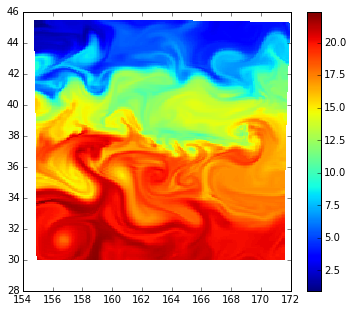

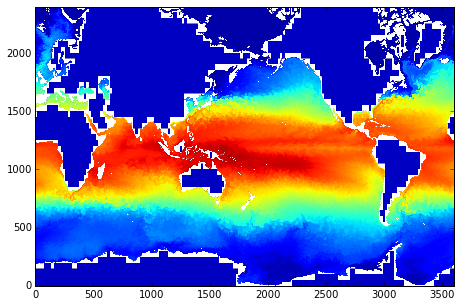

In [101]:
plt.figure(figsize=(6,5))
plt.pcolormesh(tlon[jmin:jmax, imin:imax], tlat[jmin:jmax, imin:imax], SST_domain[0])
plt.colorbar()

plt.figure(figsize=(12,5))
plt.imshow(SST[0], origin='bottom')

In [84]:
Nt, Ny, Nx = SST_domain.shape

lon = tlon[jmin:jmax, imin:imax]
lat = tlat[jmin:jmax, imin:imax]
dlon = lon[np.round(np.floor(lon.shape[0]*0.5)), np.round(
                         np.floor(lon.shape[1]*0.5))+1] - lon[np.round(
                         np.floor(lon.shape[0]*0.5)), np.round(np.floor(lon.shape[1]*0.5))]
dlat = lat[np.round(np.floor(lat.shape[0]*0.5))+1, np.round(
                         np.floor(lat.shape[1]*0.5))] - lat[np.round(
                         np.floor(lat.shape[0]*0.5)), np.round(np.floor(lat.shape[1]*0.5))]
dx = gfd.A*np.cos(np.radians(lat[np.round(
                         np.floor(lat.shape[0]*0.5)),np.round(
                         np.floor(lat.shape[1]*0.5))]))*np.radians(dlon)
dy = gfd.A*np.radians(dlat)        

#Ti = SST_domain.copy()
SST_sum = np.zeros((Ny,Nx))

#plt.figure(figsize=(12,6))
#plt.subplot(121)
#plt.imshow(Ti[0], origin='bottom')
#plt.colorbar()

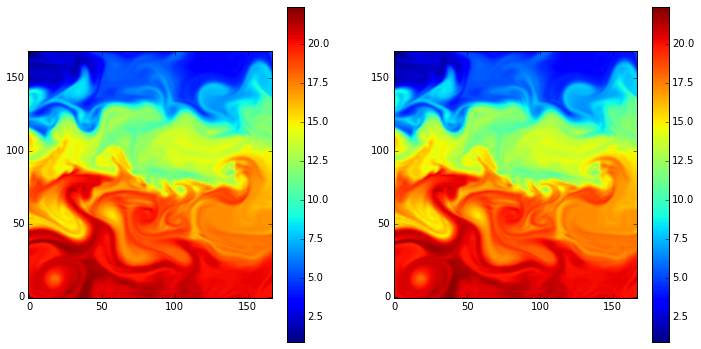

In [85]:
j=0

Ti = SST_domain[j].copy()

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(Ti, origin='bottom')
plt.colorbar()
plt.subplot(122)
plt.imshow(SST_domain[j], origin='bottom')
plt.colorbar()

np.testing.assert_almost_equal(SST_domain[j], Ti)

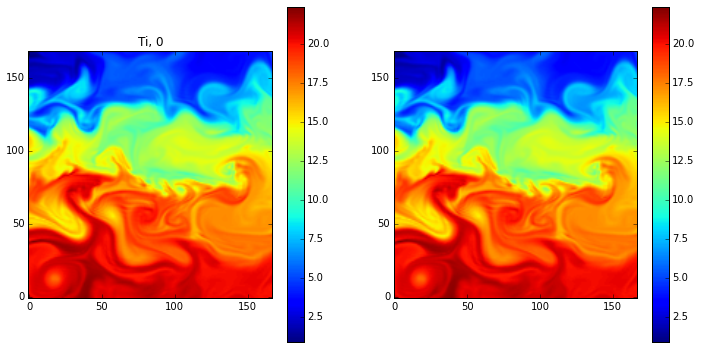

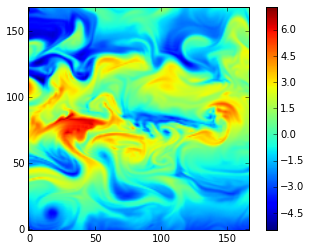

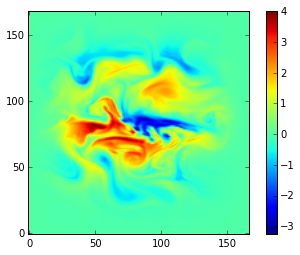

(169, 167)


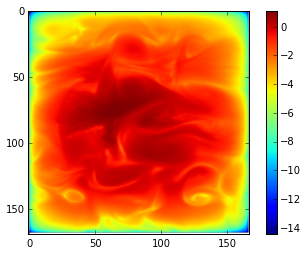

In [86]:
for j in range(Nt):
    #Ti = np.zeros((Ny,Nx))
    Ti = SST_domain[j].copy()
    
    if j == 0:
        f1 = plt.figure(figsize=(12,6))
        ax1 = f1.add_subplot(121)
        ims = ax1.imshow(Ti, origin='bottom')
        ax1.set_title("Ti, %g" % j )
        plt.colorbar(ims)
        ax2 = f1.add_subplot(122)
        ims = ax2.imshow(SST_domain[j], origin='bottom')
        plt.colorbar(ims)
        plt.show()
    
    
    # Detrend data
    d_obs = np.reshape(Ti, (Nx*Ny,1))
    G = np.ones((Ny*Nx,3))
    for i in range(Ny):
        G[Nx*i:Nx*i+Nx, 0] = i+1
        G[Nx*i:Nx*i+Nx, 1] = np.arange(1, Nx+1)    
    m_est = np.dot(np.dot(lin.inv(np.dot(G.T, G)), G.T), d_obs)
    d_est = np.dot(G, m_est)
    Lin_trend = np.reshape(d_est, (Ny, Nx))
    Ti -= Lin_trend

    
    if j == 0:
        f2 = plt.figure()
        ax1 = f2.add_subplot(111)
        ims = ax1.imshow(Ti, origin='bottom')
        plt.colorbar(ims)
        plt.show()


    # Window data (Hanning window)
    windowx = sig.hann(Nx)
    windowy = sig.hann(Ny)
    window = windowx*windowy[:,np.newaxis] 
    Ti *= window
    
    if j == 0:
        plt.figure()
        plt.imshow(Ti, origin='bottom')
        plt.colorbar()
        plt.show()
    
    SST_sum += Ti**2

plt.figure()
plt.imshow(np.log10(SST_sum/Nt))
plt.colorbar()

print SST_sum.shape
E_spatial = (SST_sum/Nt).sum()  #[C^2]

In [89]:
p = popmodel.POPFile(fname)

Nt_Feb, Nx, Ny, k, l, tilde_Feb, breve_Feb, Ki, isospec_Feb, area, lon, lat, frac, MAX_LAND = p.power_spectrum_2d()
dk = np.diff(k)[0]
dl = np.diff(l)[0]

sstanalysis/popmodel.py:277: RuntimeWarning: invalid value encountered in divide
  T = np.roll(self.nc.variables[varname][:], roll)[..., jmin:jmax, imin:imax]


<matplotlib.colorbar.Colorbar instance at 0x7f20848ce9e0>

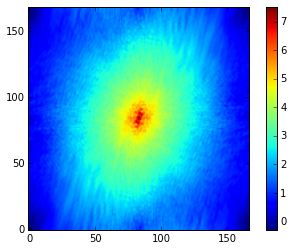

In [90]:
plt.figure()
plt.imshow(np.log10(tilde_Feb), origin='bottom')
plt.colorbar()

In [91]:
E_spectra = (tilde_Feb).sum()

In [92]:
print E_spatial/E_spectra

Patch_spatial = E_spatial*dx*dy
Patch_spectra = E_spectra/((Nx*Ny)**2*dk*dl)
print Patch_spatial/Patch_spectra

3.54320943447e-05
0.999999998689


In [93]:
Patch_spectra = breve_Feb.sum()
E_spectra = (Nx*Ny)**2*dk*dl*(breve_Feb).sum()
print Patch_spatial/Patch_spectra

0.999999998689
